In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

# Set up the plotting style
sns.set(style="whitegrid")

# Load the engineered logs
logs_df = pd.read_csv("/Users/davidstroud/cloud_logs/anomaly_detection/engineered_logs_10000.csv")

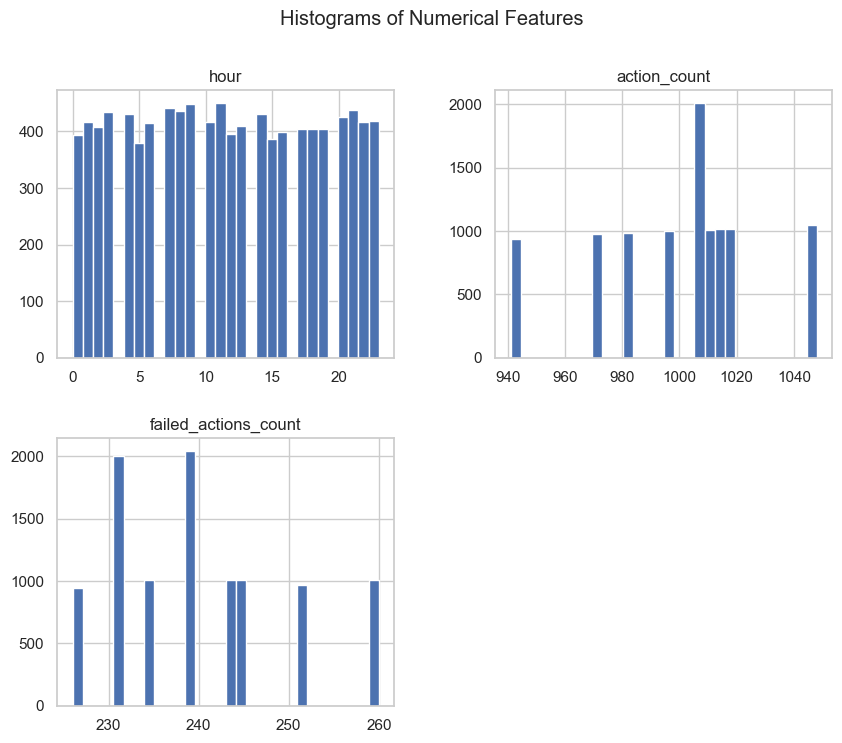

In [6]:

# Plot histograms for numerical features
numerical_columns = ['hour', 'action_count', 'failed_actions_count']
logs_df[numerical_columns].hist(bins=30, figsize=(10, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()

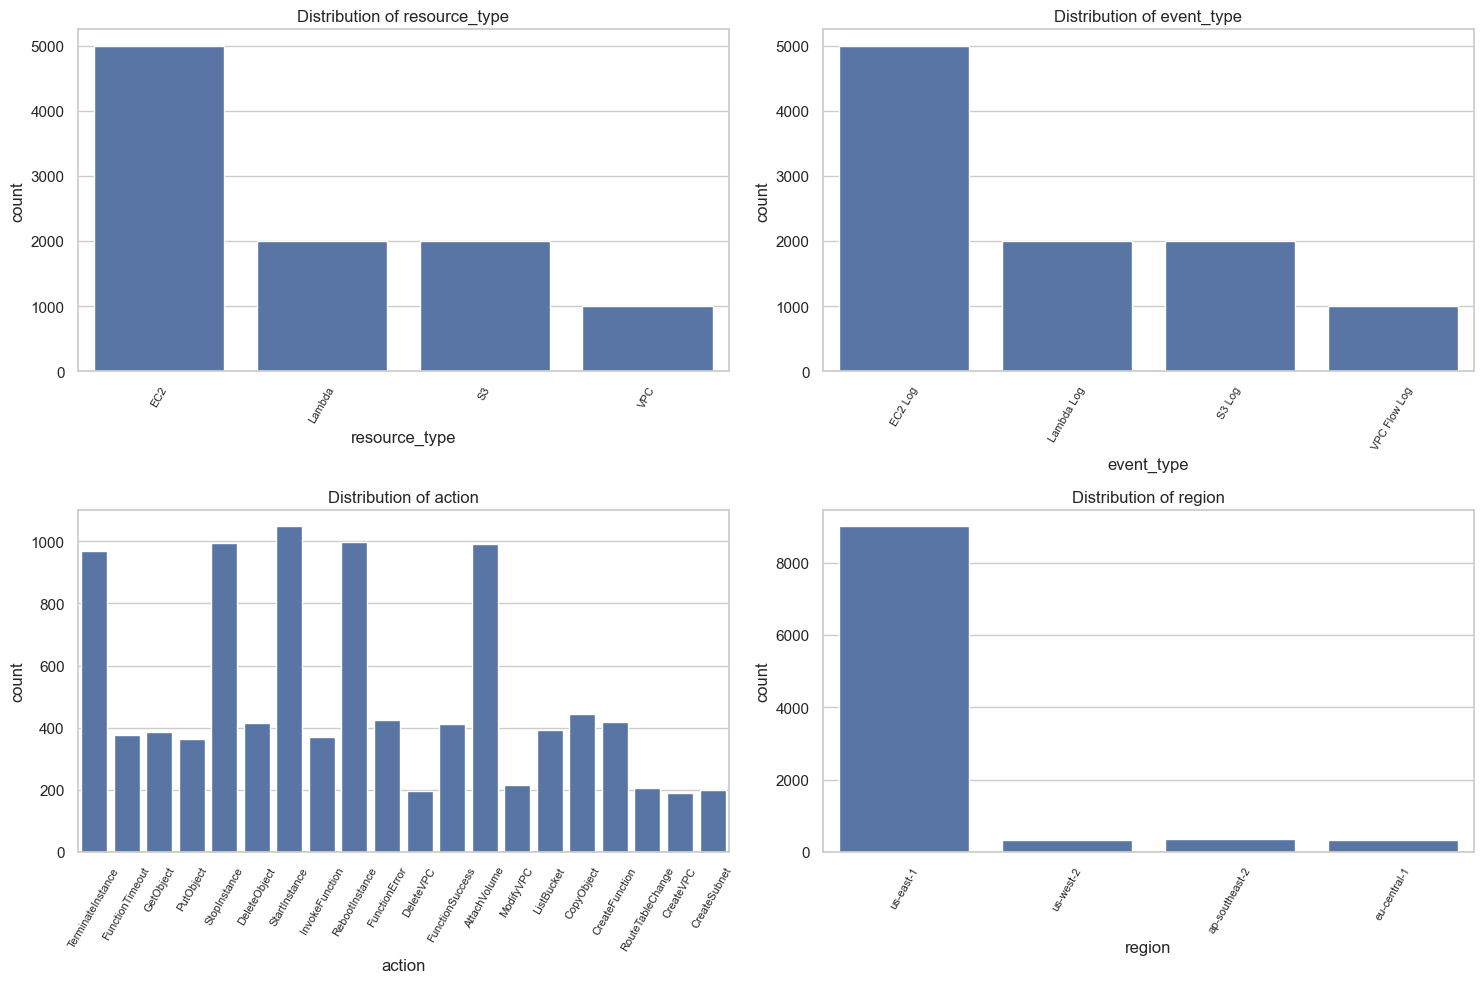

In [3]:
categorical_columns = ['resource_type', 'event_type', 'action', 'region']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, col in enumerate(categorical_columns):
    sns.countplot(data=logs_df, x=col, ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_title(f'Distribution of {col}')
    
    # Make x-axis labels vertical and adjust font size
    axes[idx // 2, idx % 2].tick_params(axis='x', rotation=60, labelsize=8)
    
    # Optionally, limit the number of unique labels displayed if they are too many
    if len(logs_df[col].unique()) > 20:
        axes[idx // 2, idx % 2].set_xticks([])

plt.tight_layout()
plt.show()

In [ ]:


# # Drop the 'timestamp' column from the DataFrame
# logs_df_no_timestamp = logs_df.drop(columns=['timestamp'])

# # One-hot encode the 'user' column
# logs_df_encoded = pd.get_dummies(logs_df_no_timestamp, columns=['user'])

# # Compute the correlation matrix
# correlation_matrix = logs_df_encoded.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()



In [ ]:
# Response Code Definitions:
# 200: OK - The request was successful.
# 404: Not Found - The server could not find the requested resource.
# 500: Internal Server Error - The server encountered an unexpected condition.

# Analyzing response codes in logs_df

# Count the occurrences of each response code
response_code_counts = logs_df['response_code'].value_counts()

# Plot the distribution of response codes
plt.figure(figsize=(10, 6))
sns.countplot(data=logs_df, x='response_code')
plt.title('Distribution of Response Codes')
plt.show()


In [ ]:
# Plot the distribution of geo anomalies
plt.figure(figsize=(10, 6))
sns.countplot(data=logs_df, x='region', hue='geo_anomaly')
plt.title('Geo Anomaly Analysis by Region')
plt.show()
